# Notebook For Monte Carlo Project
#### Written as a requirement for Degree Probability and Finance at Ecole Polytechnique and Sorbonne University
### Author : Oussama Elghodhben


This notebook will contain a general structure for Multilevel Monte Carlo problems and a different class implementation for each individual problem that implements a function which defines the fine and coarse path approximation for a given level. In other words, applying the method to different problem only requires the definition of the problem class that implements the evalute function which returns the fine and coarse approximations. The rest of the code would stay the same.

## The Multilevel Structure (problem independent implementation)

In [227]:
import numpy
import numpy.linalg
import timeit
from datetime import datetime
import numpy
from math import sqrt
import sys
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm


In [228]:
def mlmc(N0, eps, mlmc_fn, alpha_0, beta_0, gamma_0, problem,  *args, **kwargs):
    theta = 0.25
    L = 2
    Nl = np.zeros(L)
    S = np.zeros((2, L))
    C = np.zeros(L)
    dNl = N0 * np.ones(L)

    while sum(dNl) > 0:
        for l in range(0, L):
            if dNl[l] > 0:
                sums, cost = mlmc_fn(l, int(dNl[l]), problem, *args, **kwargs)
                Nl[l] += dNl[l]
                S[0, l] += sums[0]
                S[1, l] += sums[1]
                C[l] += cost

        mean = np.abs(S[0, :] / Nl)
        var = np.maximum(0, S[1, :] / Nl - mean ** 2)
        cost_per_level = C / Nl

        for l in range(3, L + 1):
            mean[l - 1] = max(mean[l - 1], 0.5 * mean[l - 2] / 2 ** alpha)
            var[l - 1] = max(var[l - 1], 0.5 * var[l - 2] / 2 ** beta)

        if alpha_0 <= 0:
            A = np.ones((L - 1, 2))
            A[:, 0] = range(1, L)
            x = np.linalg.lstsq(A, np.log2(mean))[0]
            alpha = max(0.5, -x[0])
        else :
            alpha = alpha_0

        if beta_0 <= 0:
            A = np.ones((L - 1, 2))
            A[:, 0] = range(1, L)
            x = np.linalg.lstsq(A, np.log2(var))[0]
            beta = max(0.5, -x[0])
        else :
            beta = beta_0

        if gamma_0 <= 0:
            A = np.ones((L - 1, 2))
            A[:, 0] = range(1, L)
            x = np.linalg.lstsq(A, np.log2(cost_per_level))[0]
            gamma = max(0.5, x[0])
        else :
            gamma = gamma_0

        optimal_samples = np.ceil(np.sqrt(var / cost_per_level) * sum(np.sqrt(var * cost_per_level))
                                  / ((1 - theta) * eps ** 2))
        dNl = np.maximum(0, optimal_samples - Nl)

        if sum(dNl > 0.01 * Nl) == 0:
            remaining_error = mean[-1] / (2 ** alpha - 1.0)
            if remaining_error > np.sqrt(theta) * eps:
                L += 1
                Nl = np.append(Nl, 0.0)
                S = np.column_stack([S, [0, 0]])
                C = np.append(C, C[-1] * 2 ** gamma)
                dNl = np.append(dNl, N0)

    P = sum(S[0, :] / Nl)

    return P, Nl, cost_per_level

In [229]:
def eval_fn(l, N, problem, *args, **kwargs):
    problems = {'GBM': GBM, 'Heston': Heston}
    pb = problems[problem](*args, **kwargs)
    return pb.eval_Y(l, N)

In [230]:
def mlmc_test(fn, problem, N, L, N0, l_eps, *args, **kwargs):
    
    results = {'mean_y': [], 'mean_p': [], 'var_y': [], 'var_p': [] , 'kurt': [], 'test': [], 'cost': []}

    for l in tqdm(range(0, L+1)):

        (res, cst) = fn(l, N, problem, *args, **kwargs)
        cst = cst/N
        res = res/N

        if l == 0:
            kurt = 0.0
        else:
            kurt = (     res[3]
                     - 4*res[2]*res[0]
                     + 6*res[1]*res[0]**2
                     - 3*res[0]*res[0]**3 ) / (res[1]-res[0]**2)**2

        results['cost'].append(cst)
        results['mean_y'].append(res[0])
        results['mean_p'].append(res[4])
        results['var_y'].append(res[1]-res[0]**2)
        results['var_p'].append(max(res[5]-res[4]**2, 1.0e-10)) # fix for cases with var = 0
        results['kurt'].append(kurt)

        if l == 0:
            t = 0
        else:
            t =          abs(       results['mean_y'][l]  +      results['mean_p'][l-1]  -      results['mean_p'][l])
            t = t / ( 3.0*(numpy.sqrt(results['var_y'][l]) + numpy.sqrt(results['var_p'][l-1]) + numpy.sqrt(results['var_p'][l]) )/numpy.sqrt(N))
        results['test'].append(t)

    # linear regression to estimate alpha, beta and gamma
    L1 = 1
    L2 = L+1
    levels = range(L1+1, L2+1)
    alpha = max(0.5, -linregress(levels, numpy.log2(numpy.abs(results['mean_y'][L1:L2]))).slope)

    beta = max(0.5, -linregress(levels, numpy.log2(numpy.abs(results['var_y'][L1:L2]))).slope)

    gamma = linregress(levels, numpy.log2(numpy.abs(results['cost'][L1:L2]))).slope

    print(alpha, beta, gamma)
    theta = 0.25
    l_cost = []
    mc_cost = []
    Ns = []
    ls = []
    for eps in tqdm(l_eps):
        (P, Nl, Cl) = mlmc(N0, eps, fn, alpha, beta, gamma, problem, *args, **kwargs)
        Ns.append(Nl)
        ls.append(range(len(Nl)))
        l = len(Nl) - 1
        l_cost.append(numpy.dot(Nl,Cl))
        mc_cost.append(results['var_p'][-1]*Cl[l]/((1.0 -theta)*eps**2))
    return results, np.array(l_cost), np.array(mc_cost), np.array(ls), np.array(Ns)

In [231]:
def mlmc_plot(l_eps, results, mc_cost, std_cost, ls , Ns):
    """
    Generate MLMC diagnostic plots based on results returned by mlmc_test.

    Inputs:
      results: dictionary containing the results returned by mlmc_test
      mc_cost: cost per sample computed from MLMC complexity tests
      std_cost: standard Monte Carlo cost per sample
      error_bars: flag to add error bars in plots of level differences

    Outputs:
      Matplotlib figure(s) showing various MLMC diagnostic plots
    """

    width = 10
    height = 18
    plt.figure(figsize=([width, height]))

    # Var[P_l - P_{l-1}] per level
    plt.subplot(3, 2, 1)
    plt.plot(range(len(results['mean_y'])), np.log2(results['var_p']), label=r'$P_\ell$')
    plt.plot(range(1, len(results['mean_y'])), np.log2(results['var_y'][1:]), label=r'$P_\ell - P_{\ell-1}$')
    plt.xlabel('level $\ell$')
    plt.ylabel(r'$\mathrm{log}_2(\mathrm{variance})$')
    plt.legend(loc='lower left', fontsize='medium')
    plt.title('Var[P_l - P_{l-1}] per level')

    # E[|P_l - P_{l-1}|] per level
    plt.subplot(3, 2, 2)
    plt.plot(range(len(results['mean_y'])), np.log2(np.abs(results['mean_p'])), label=r'$P_\ell$')
    plt.plot(range(1, len(results['mean_y'])), np.log2(np.abs(results['mean_y'][1:])), label=r'$P_\ell - P_{\ell-1}$')
    plt.xlabel('level $\ell$')
    plt.ylabel(r'$\mathrm{log}_2(|\mathrm{mean}|)$')
    plt.legend(loc='lower left', fontsize='medium')
    plt.title('E[|P_l - P_{l-1}|] per level')

    # cost per level
    plt.subplot(3, 2, 3)
    plt.plot(range(len(results['cost'])), np.log2(results['cost']), '*--')
    plt.xlabel('level $\ell$')
    plt.ylabel(r'$\log_2$ cost per sample')
    plt.title('Cost per level')

    # kurtosis per level
    plt.subplot(3, 2, 4)
    plt.plot(range(1, len(results['kurt'])), results['kurt'][1:], '*--')
    plt.xlabel('level $\ell$')
    plt.ylabel('kurtosis')
    plt.title('Kurtosis per level')

    # number of samples per level
    plt.subplot(3, 2, 5)
    for (eps, ll, n) in zip(l_eps, ls, Ns):
        plt.semilogy(ll, n, label=eps, markerfacecolor='none', clip_on=False)
    plt.xlabel('level $\ell$')
    plt.ylabel('$N_\ell$')
    plt.legend(loc='upper right', frameon=True, fontsize='medium')
    plt.title('Number of Samples per Level')

    # Normalized cost for given accuracy
    eps = np.array(l_eps)
    I = np.argsort(eps)
    plt.subplot(3, 2, 6)
    plt.loglog(eps[I], eps[I]**2 * std_cost[I],  '*-',  label='Std MC', clip_on=False)
    plt.loglog(eps[I], eps[I]**2 * mc_cost[I], '*--', label='MLMC',   clip_on=False)
    plt.xlabel(r'accuracy $\varepsilon$')
    plt.ylabel(r'$\varepsilon^2$ cost')
    plt.legend(fontsize='medium')
    plt.title('Normalized Cost for Given Accuracy')

    plt.show()


# Problem definitions

In [232]:
class GBM :
    def __init__(self, S0, r, q, sigma, T, K):
        self.S0 = S0
        self.r = r
        self.q = q
        self.sigma = sigma
        self.T = T
        self.K = K
    def eu_call(self, X):
        return np.exp(-self.r * self.T) * np.maximum(0, X - self.K)
    def digital_call(self, X):
        return np.exp(-self.r * self.T) * np.heaviside(X - self.K, 0)
    def eval_Y(self, l, N):
        N = int(N)
        nf = self.T * 2**l
        nc = nf/2
        dtf = self.T/nf
        dtc = self.T/nc
        
        l_y = np.zeros(6)
        
        Xf = self.S0 * np.ones(N)
        Xc = self.S0 * np.ones(N)
        start = time.perf_counter()
        if l == 0 :
            dWf = np.sqrt(dtf)* np.random.randn(N)
            Xf += self.r * Xf * dtf + self.sigma * Xf * dWf
        else :
            for i in range(int(nc)):
                dWc = np.zeros(N)
                for j in range(2):
                    dWf = np.sqrt(dtf) * np.random.randn(N)
                    dWc += dWf
                    Xf += self.r * Xf * dtf + self.sigma * Xf * dWf
                Xc += self.r * Xc * dtc + self.sigma * Xc * dWc
        Pf = self.eu_call(Xf)
        if l == 0 :
            Pc = 0
        else :
            Pc = self.eu_call(Xc)
        l_y = np.array([np.sum(Pf - Pc), np.sum((Pf - Pc)**2), np.sum((Pf - Pc)**3), np.sum((Pf - Pc)**4), np.sum(Pf), np.sum((Pf)**2)])
        end = time.perf_counter()
        cost = end - start
        return l_y, cost

In [233]:
class Heston :
    def __init__(self):
        pass

# Testing

100%|██████████| 9/9 [00:00<00:00, 69.93it/s]


1.1880142401834903 0.9560769429714439 0.8242681095145225


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]
C:\Users\oussama\AppData\Local\Temp\ipykernel_14040\4003146927.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return results, np.array(l_cost), np.array(mc_cost), np.array(ls), np.array(Ns)


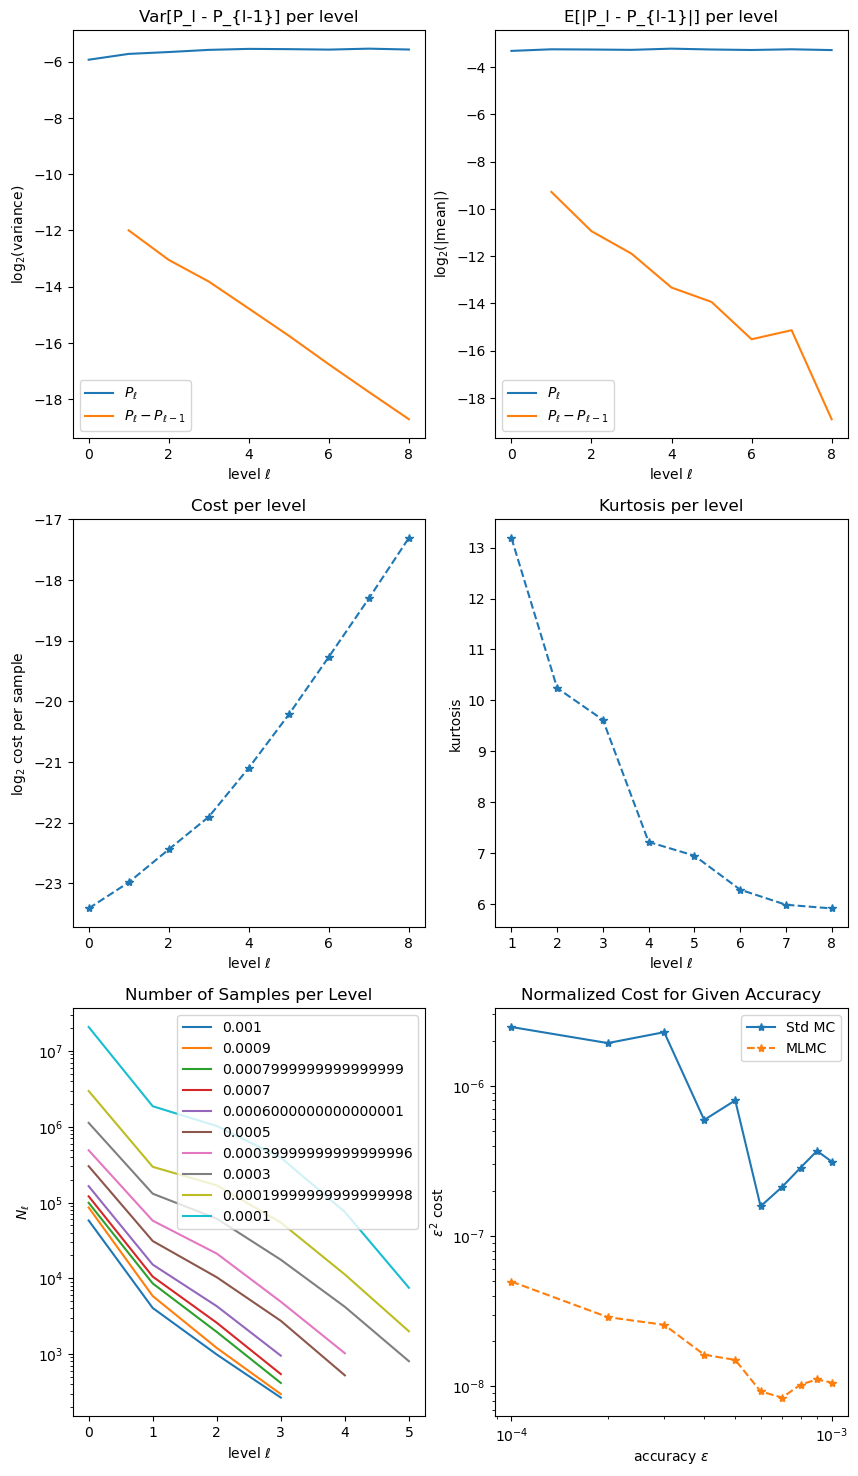

In [235]:
T = 1
K = 1
S0 = 1
r = 0.05
q = 0
sigma = 0.2
problem = 'GBM'
N = 1e4
N0 = 1e2
L = 8
l_eps = np.flip(np.linspace(0.0001, 0.001, 10))

results, mlmc_cost, mc_cost, ls, Ns = mlmc_test(eval_fn, problem, N, L, N0, l_eps, S0, r, q, sigma, T, K)
mlmc_plot(l_eps, results, mlmc_cost, mc_cost, ls, Ns)